# <b>Tempest Techies</b>
## Team Members
- Surya Prakash S
- Nihar Sagar G
- Saipushkar Nagaraj


## The Project is done in 3 steps :
1. Preprocessing of data and feature engineering
2. Identifying the right algorithm by testing out multiple different algorithms.
3. Fine-tuning the algorithm by manipulating hyper-parameters


## Importing Libraries

In [384]:
#importing libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,IterativeImputer



## <h2><b> Initialising the DataFrame </b></h2>

The  heat map shown below shows the correlation between each factor, we observe Air temperature to be a very influential factor for the Sea Surface temperature

,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
count,104409.000000,104409.000000,104409.000000,104409.000000,104409.000000,89839.000000,89839.000000,65615.000000,96571.000000,104409.000000
mean,92.710715,6.753517,15.781666,0.559597,-53.070046,-3.505847,0.451069,81.245035,26.689702,27.535275
std,2.941256,3.450238,8.796154,4.586084,134.416226,3.222261,2.927329,5.371216,1.905292,2.167564
min,80.000000,1.000000,1.000000,-8.810000,-180.000000,-12.400000,-10.800000,54.000000,17.050000,17.340000
25%,91.000000,4.000000,8.000000,-2.010000,-140.200000,-5.900000,-1.500000,77.600000,25.750000,26.450000
50%,93.000000,7.000000,16.000000,0.010000,-110.200000,-4.200000,0.400000,81.200000,27.160000,28.080000
75%,95.000000,10.000000,23.000000,4.990000,147.000000,-1.800000,2.400000,84.800000,28.060000,29.190000
max,96.000000,12.000000,31.000000,9.050000,171.100000,12.500000,11.000000,99.900000,31.480000,31.270000


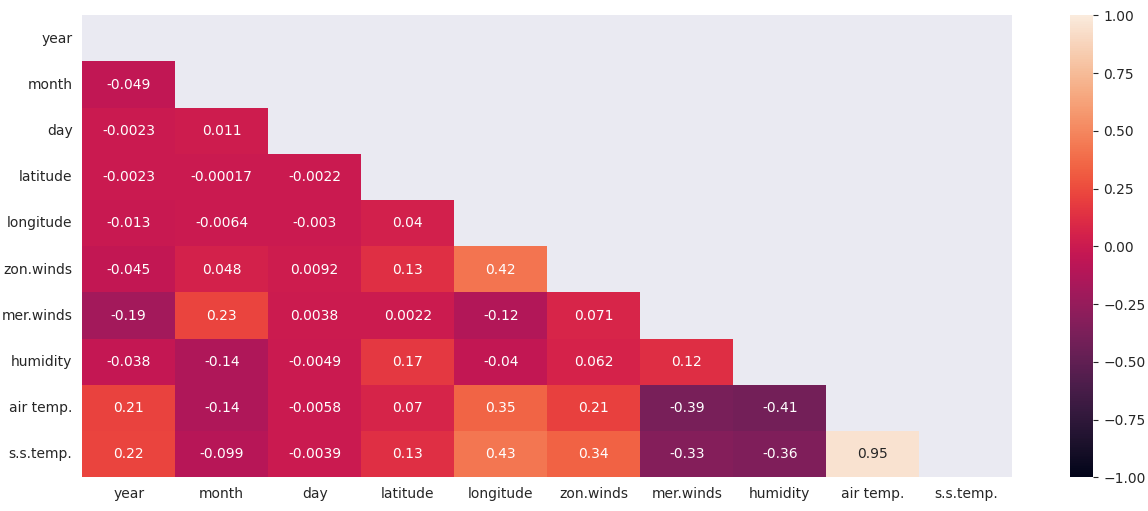

In [438]:
data=pd.read_csv('./train.csv')
dataFrame=data.copy()
dataFrame['year']=dataFrame['year'] % 100 #scaling down year to prevent weight imbalance
#Target variables are not missing so no need to do anything

mask = np.zeros_like(dataFrame.corr())#plotting correlation
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 6))
    ax = sns.heatmap(dataFrame.corr(), annot = True, mask=mask, vmax=1,vmin=-1, square=False)

dataFrame.describe()

<b>The 'year' parameter is normalised to a comparable degree with the other parameters so it doest play a huge role during fitting

In [386]:

dataFrame=data.copy()
dataFrame.year=dataFrame.year%100
y=dataFrame['s.s.temp.']

### We have used MI scores to figure out which features could be used for training our model

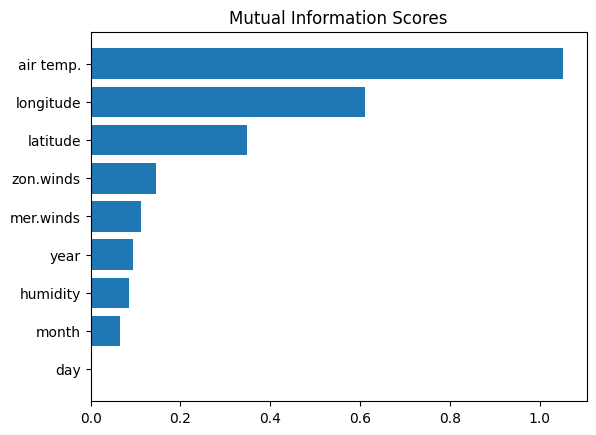

In [387]:
dFrame_copy=dataFrame.copy()
dFrame_copy.drop(['s.s.temp.'],axis=1,inplace=True)
dFrame_copy.fillna(10,inplace=True)
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    # print('scores: ',scores)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_scores = mutual_info_regression(dFrame_copy, y, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=dFrame_copy.columns)
mi_scores = mi_scores.sort_values(ascending=False)
plot_mi_scores(mi_scores)

    

We originally dropped the day column as it's correlation with s.s.temp seemed too low and further training using this data might have lead to overfittingWe have dropped the day column as it's correlation with s.s.temp is too low and further training using this data may lead to overfitting

EDIT : Upon testing the model , it was found that including the 'day' parameter made the efficiency and accuracy of the model marginally better.

In [388]:
features=['air temp.','latitude','longitude','humidity','zon.winds','mer.winds','year','month','day']
X=dataFrame[features]

## <b>Data Visualization</b>

The following graphs depict the relation between the sea surface temperature and other factors that may influence it.

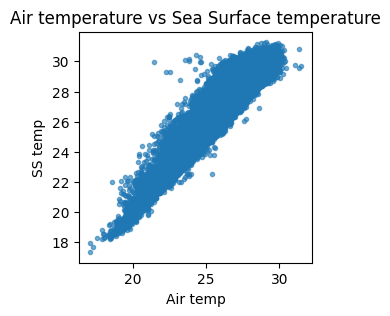

In [389]:
#testing for correlations between sea surface temperature and other factors
plt.figure(figsize=(3,3))
plt.scatter(X['air temp.'],y,marker='.',alpha=0.6)
plt.title('Air temperature vs Sea Surface temperature')
plt.xlabel('Air temp')
plt.ylabel('SS temp')
plt.show(
)

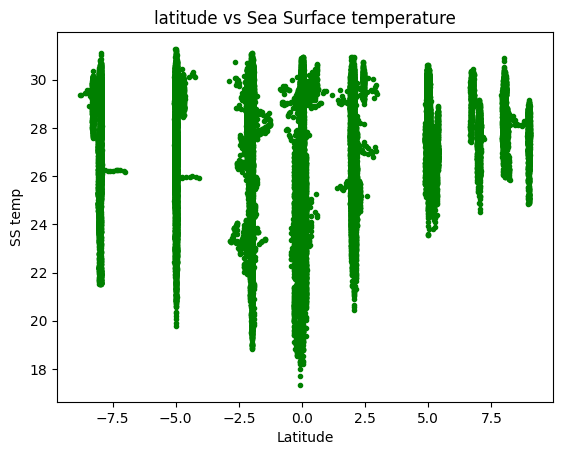

In [390]:
plt.scatter(X['latitude'],y,color='green',marker='.')
plt.title('latitude vs Sea Surface temperature')
plt.xlabel('Latitude')
plt.ylabel('SS temp')
plt.show()

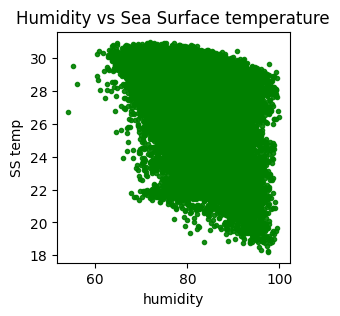

In [391]:
plt.figure(figsize=(3,3))
plt.scatter(X['humidity'],y,color='green',marker='.',alpha=0.9)
plt.title('Humidity vs Sea Surface temperature')
plt.xlabel('humidity')
plt.ylabel('SS temp')
plt.show()

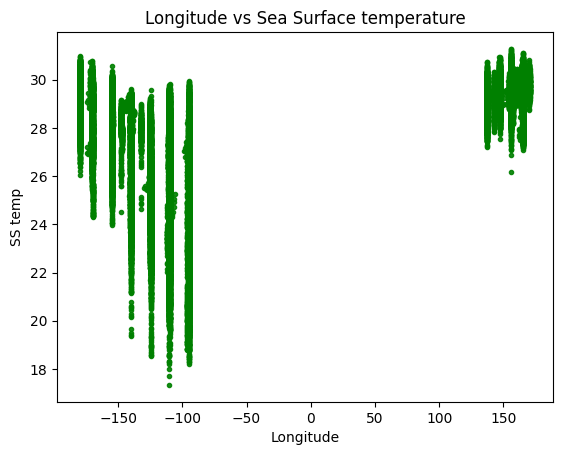

In [392]:
plt.scatter(X['longitude'],y,color='green',marker='.',alpha=0.9)
plt.title('Longitude vs Sea Surface temperature')
plt.xlabel('Longitude')
plt.ylabel('SS temp')
plt.show()

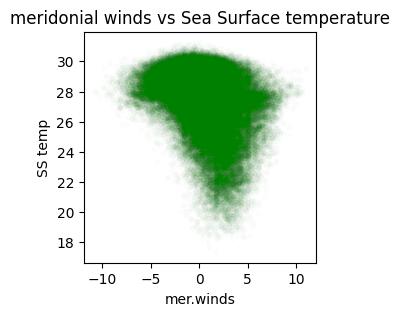

In [393]:
plt.figure(figsize=(3,3))
plt.scatter(X['mer.winds'],y,color='green',marker='.',alpha=0.01)
plt.title('meridonial winds vs Sea Surface temperature')
plt.xlabel('mer.winds')
plt.ylabel('SS temp')
plt.show()

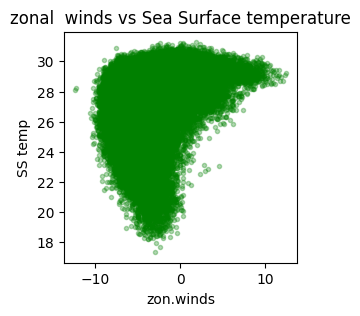

In [394]:
plt.figure(figsize=(3,3))
plt.scatter(X['zon.winds'],y,color='green',marker='.',alpha=0.3)
plt.title('zonal  winds vs Sea Surface temperature')
plt.xlabel('zon.winds')
plt.ylabel('SS temp')
plt.show()

0         92
1         89
2         93
3         95
4         95
          ..
104404    89
104405    95
104406    84
104407    96
104408    93
Name: year, Length: 104409, dtype: int64


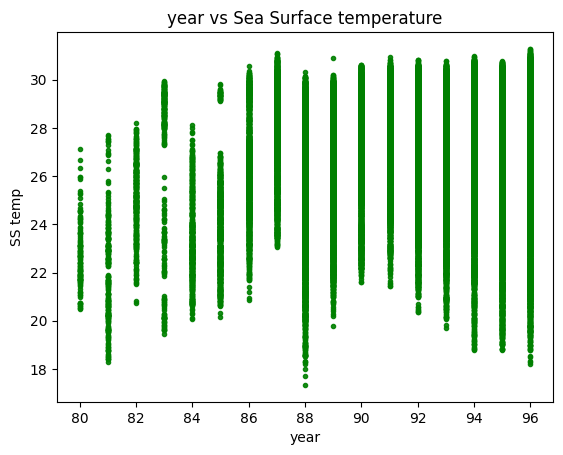

In [372]:

plt.scatter(X['year'],y,color='green',marker='.',alpha=0.9)
plt.title('year vs Sea Surface temperature')
plt.xlabel('year')
plt.ylabel('SS temp')
plt.show()

## <h2> <b>Linear Regression Algorithm

This model was implemented with data where all rows with missing entries were dropped.
We get a rather satisfactory result as air temperature has an almost linear relatioship with s.s.temp(Target) and linear regression is able to capture
that well.

In [395]:
#features used


# target_features=dataFrame['s.s.temp.'].values
# training_features=dataFrame[features].values
# print(training_features)
df_drop=dataFrame.dropna(axis=0)
y_drop=df_drop['s.s.temp.']
X_drop=df_drop[features]

# df_drop.info()

MLalgorithm=LinearRegression()
X_train,X_val,y_train,y_val=train_test_split(X_drop,y_drop,test_size=0.2,train_size=0.8,random_state=1)
MLmodel=MLalgorithm.fit(X_train,y_train)

print(MLmodel.score(X_val,y_val))

#scores=model_selection.cross_val_score(MLalgorithm,training_features,target_features,scoring='accuracy',cv=50)
#print(scores)




0.9254426354684371


## <h2><b>Descision Tree Algorithm

This model was  implemented by dropping all the null values in the dataset , We get a pretty good accuracy with this algorithm. Hyper-tuning the parameters for this algorithm might help increase the accuracy even more.

In [398]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

df_drop=dataFrame.dropna(axis=0)
y_drop=df_drop['s.s.temp.']
X_drop=df_drop[features]

X_train, X_val, y_train, y_val = train_test_split(X_drop, y_drop, random_state=1)
model = DecisionTreeRegressor(max_leaf_nodes=500,random_state=1)
model.fit(X_train,y_train)
model.score(X_val,y_val)

0.9574504284368732

##  <h2> <b>Random Forest Algorithm

This model was  implemented by dropping all the null values in the dataset , We get a pretty good accuracy with this algorithm too. Hyper-tuning the parameters for this algorithm will help increase the accuracy even more. But the processing time can be very <b>slow</b>!!!

In [399]:
from sklearn.ensemble import RandomForestRegressor

df_drop=dataFrame.dropna(axis=0)

y_drop=df_drop['s.s.temp.']
X_drop=df_drop[features]

X_train,X_val, y_train, y_val = train_test_split(X_drop, y_drop, random_state=0)
model = RandomForestRegressor(n_estimators=200,random_state=1)
model.fit(X_train, y_train)
print(model.score(X_val,y_val))


0.9755759813436722


##  <h2> <b>Extreme Gradient Boosting


As we could see XGB is much faster and more accurate when compared to Random Forests. Also with proper tuning this can get much better. So we have chosen this as our model moving forward

In [440]:
from xgboost import XGBRegressor
df_drop=dataFrame.dropna(axis=0)

y_drop=df_drop['s.s.temp.']
X_drop=df_drop[features]

X_train,X_val, y_train, y_val = train_test_split(X_drop, y_drop, random_state=0)
model = XGBRegressor(random_state=1)
model.fit(X_train, y_train)
print(model.score(X_val,y_val))

0.9770149277514159


# <h1><b>Filling In Missing Data</b></h1>
<p>We have used SimpleImputer( ) to fill in the missing values with a median of the training dataset.</p>
<p>We had also tried KNNImputer( ) and IterativeImputer( ) with varying parameters but they fell short when compared to SI( ) during tests, atleast we weren't able to tune it well enough for them to outperform SI() </p>
<p>We have split the data before imputing to prevent data leakage</p>

In [400]:

myimputer=SimpleImputer(strategy='median') # Algorithm with simple imputer
# myimputer=IterativeImputer(max_iter=100,initial_strategy='median')
# myimputer=KNNImputer(max_iter=100)

X_train_full,X_val_full,y_train,y_val=train_test_split(dataFrame.drop(['s.s.temp.'],axis=1),y,test_size=0.2,train_size=0.8,random_state=1)
X_train_full=pd.DataFrame(myimputer.fit_transform(X_train_full))
X_val_full=pd.DataFrame(myimputer.transform(X_val_full))
X_val_full.columns=dataFrame.drop(['s.s.temp.'],axis=1).columns
X_train_full.columns=dataFrame.drop(['s.s.temp.'],axis=1).columns
X_train=X_train_full[features]
X_val=X_val_full[features]

# xgb_model=xgb.XGBRegressor(random_state=1,n_estimators=189)
# xgb_model.fit(X_train,y_train)
# xgb_model.score(X_val,y_val)

## Plotting complex relations between features
Location_groupHere we tried clustering latitude and,ongitude dand air temperature ata points to create a new Feature 'Location_group' which is meant to describe the spatial relationship to the model.

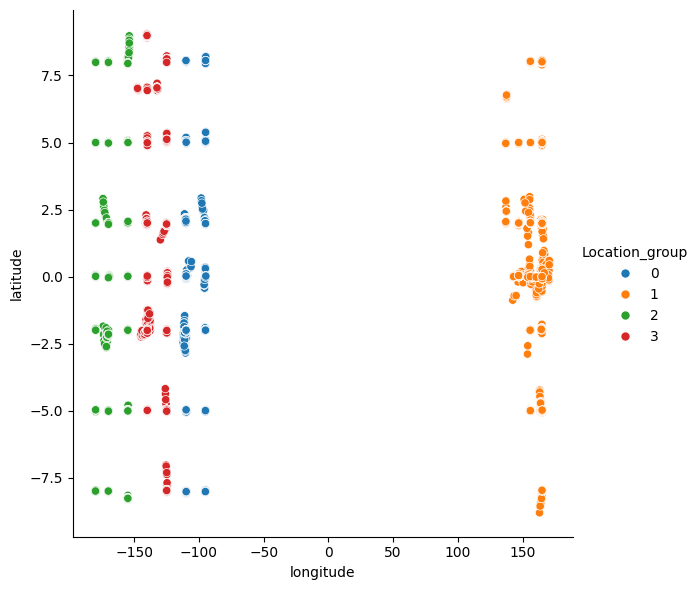

In [401]:
#XTRAIN CLUSTER-1

# print(X_imputed)
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4)  #Value chosen through trial and error
a=pd.DataFrame(X_train[['latitude','longitude','air temp.']])

a["Location_group"] = kmeans.fit_predict(a)
a["Location_group"] = a["Location_group"].astype("category")

sns.relplot(x="longitude", y="latitude", hue="Location_group", data=a, height=5)

In [402]:
#X-VAL CLUSTER 1


# print(X_imputed)
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4)  #Value chosen through trial and error
a2=pd.DataFrame(X_val[['latitude','longitude','air temp.']])

a2["Location_group"] = kmeans.fit_predict(a2)
a2["Location_group"] = a2["Location_group"].astype("category")

As we can see, the grouping is able to differentiate between the hemispheres.

### <h3>Air temperature and humidity</h3>
<p>This clustering is done between air temp. and humidity to extrapolate the relation between the two.</p>

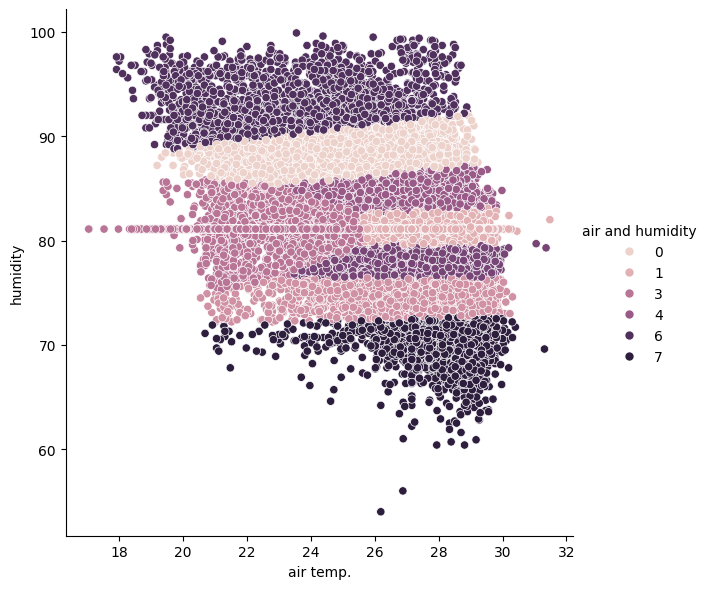

In [403]:
#X-TRAIN CLUSTER-2

kmeans2 = KMeans(n_clusters=8)  #8 for the seasons and season transitions

b=pd.DataFrame(X_train[['air temp.','humidity']])
# b.dropna(subset=['humidity'],axis=0,inplace=True)

b["air and humidity"] = kmeans2.fit_predict(b)
b["air and humidityp"] = b["air and humidity"].astype("int64")
sns.relplot(x="air temp.", y="humidity", hue="air and humidity", data=b, height=5)


In [381]:
#X-VAL CLUSTER -2

kmeans2 = KMeans(n_clusters=8)  #8 for the seasons and season transitions

b2=pd.DataFrame(X_val[['air temp.','humidity']])
# b.dropna(subset=['humidity'],axis=0,inplace=True)

b2["air and humidity"] = kmeans2.fit_predict(b2)
b2["air and humidityp"] = b2["air and humidity"].astype("int64")

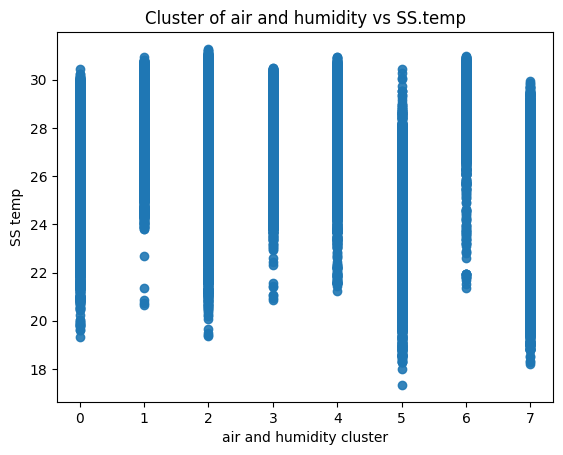

In [315]:
#X-TRAIN CLUSTER-2 
plt.scatter(b['air and humidity'],y_train,alpha=0.9)
plt.title('Cluster of air and humidity vs SS.temp')
plt.xlabel('air and humidity cluster')
plt.ylabel('SS temp')
plt.show()


### Clustering meridional and zonal winds with latitude and longitudehumi

This clustering is done among the parameters meridional and zonal winds with latitude and longitudeetween the two. meridional and zonal winds wthese featuresitude and longitude

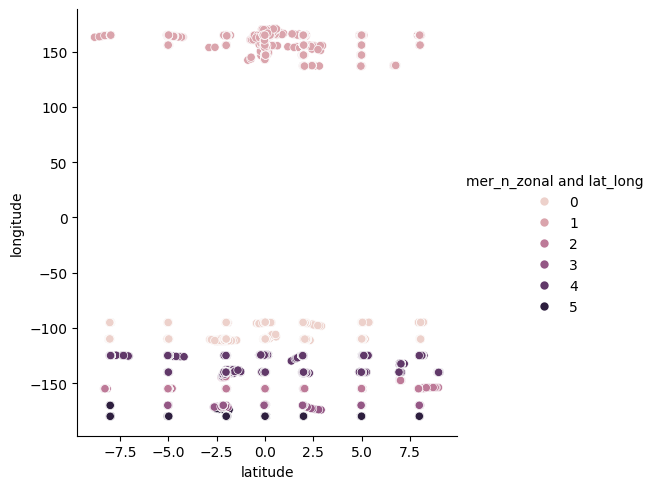

In [428]:
#X-TRAIN CLUSTER -3 

from sklearn.cluster import KMeans
kmeans3 = KMeans(n_clusters=6) 
# X_train['month']=dataFrame['month']

c=pd.DataFrame(pd.DataFrame(X_train_full[['mer.winds','zon.winds','latitude','longitude']]))

# c=pd.DataFrame
c["mer_n_zonal and lat_long"] = kmeans3.fit_predict(c)
c["mer_n_zonal and lat_long"] = c["mer_n_zonal and lat_long"].astype("int64")
sns.relplot(x="latitude", y="longitude", hue="mer_n_zonal and lat_long", data=c, height=5)


In [430]:
#X-Val CLUSTER -3 

from sklearn.cluster import KMeans
kmeans3 = KMeans(n_clusters=6) 
# X_train['month']=dataFrame['month']

c2=pd.DataFrame(pd.DataFrame(X_val_full[['mer.winds','zon.winds','latitude','longitude']]))

# c=pd.DataFrame
c2["mer_n_zonal and lat_long"] = kmeans3.fit_predict(c2)
c2["mer_n_zonal and lat_long"] = c2["mer_n_zonal and lat_long"].astype("int64")


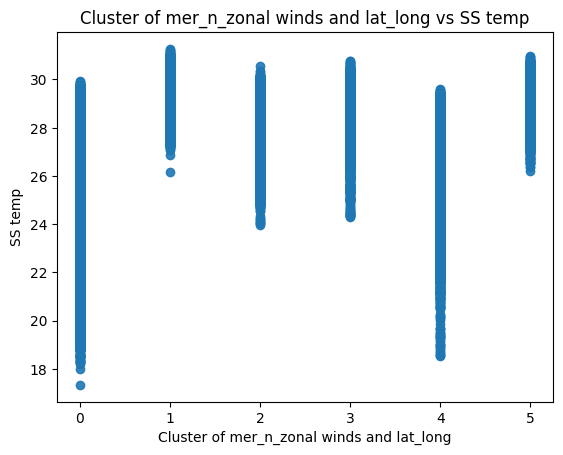

In [434]:
#X-TRAIN - CLUSTER 3
plt.scatter(c['mer_n_zonal and lat_long'],y_train,alpha=0.9)
plt.title('Cluster of mer_n_zonal winds and lat_long vs SS temp')
plt.xlabel('Cluster of mer_n_zonal winds and lat_long')
plt.ylabel('SS temp')
plt.show()

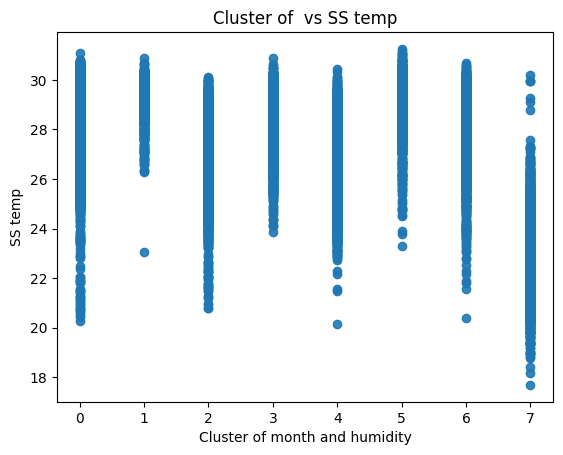

In [34]:
#X-VAL CLUSTER 3
plt.scatter(c2['month and humidity'],y_val,alpha=0.9)
plt.title('Cluster mer_n_zonal winds and lat_long of  vs SS temp')
plt.xlabel('Cluster of month and humidity')
plt.ylabel('SS temp')
plt.show()

### Clustering Zonal winds and Meridonial winds

Zonal Winds and Meridonial Winds had pretty good correlation factors with respect to Sea Surface Temperature, So we tried clustering the 2 factors to check if any relation could be extrapolated

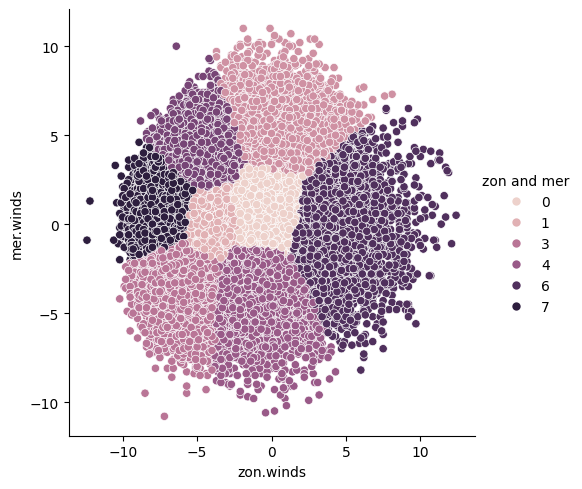

In [437]:
#X-TRAIN - CLUSTER -4


kmeans3 = KMeans(n_clusters=8)  #8 for the seasons and season transitions

d=pd.DataFrame(pd.DataFrame(X_train_full[['zon.winds','mer.winds']]))

# c=pd.DataFrame
d["zon and mer"] = kmeans3.fit_predict(d)
d["zon and mer"] = d["zon and mer"].astype("int64")
sns.relplot(x="zon.winds", y="mer.winds", hue="zon and mer", data=d, height=5)



In [441]:
#X-VAL CLUSTER 4
kmeans3 = KMeans(n_clusters=8)  #8 for the seasons and season transitions

d2=pd.DataFrame(pd.DataFrame(X_train_full[['zon.winds','mer.winds']]))

# c=pd.DataFrame
d2["zon and mer"] = kmeans3.fit_predict(d2)
d2["zon and mer"] = d2["zon and mer"].astype("int64")


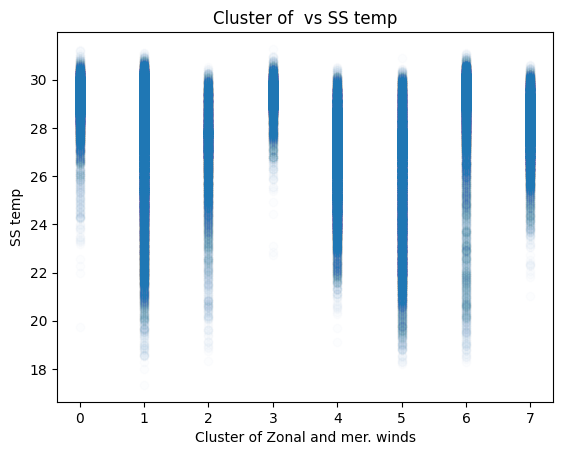

In [356]:
plt.scatter(d['zon and mer'],y_train,alpha=0.01)
plt.title('Cluster of zonal and meridional vs SS temp')
plt.xlabel('Cluster of zonal and mer. winds')
plt.ylabel('SS temp')
plt.show()

In [150]:

# #resetter
# X_train=X_train_full[features]
# X_val=X_val_full[features]




### XGB score analysis 
1. basic - 0.96506  / UB - .971191316
2. location group- 0.9635/+air_temp- .972 /
3. AIR AND HUMIDITY - .964017
4. month and humidity - .955976
5. zonal and meridional and humidity and air temp - .9641447

6. 4 and 5 - .9556147
7. 3 and 5 - .96391630
8. 2 and 5 - .9631629
9. 2 3 5 - .962607788 / UB_ .96964127


UB- model with fine tuned parameters



<h4> <b>We tried to include the features in our training dataset but they didnt end up improving the model by a significant amount to warrant its addition. </b> <h4>

# <b>XGboost model

This model gave us the best possible accuracy upon fine tuning the hyper-parameters.

## Hyperparameter Tuning

First we start with max_depth and min_child_weight. We have used GridSearch to make it easier to find the optimal values.

In [405]:

from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
X_full=dataFrame[features]
y_full=dataFrame['s.s.temp.']
X_train_n,X_val_n,y_train_n,y_val_n=train_test_split(X_full,y_full,test_size=0.2,train_size=0.8,random_state=1)

seed = 100
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda



cv_params = {'model__max_depth': [11,12,13,14], 'model__min_child_weight': [0.075,0.125,0.15]}#already searched depth 2,3,4,5,6,7,8,9,10 already searched child weight ,0.25,0.5,1,10,100
# we didnt push further with depth as we feared it might cause overfitting and also take a lot longer to execute
model=XGBRegressor(seed = seed,n_estimators = n_estimators,learning_rate = learning_rate,gamma = gamma,subsample = subsample,colsample_bytree = colsample_bytree,reg_alpha = reg_alpha,reg_lambda = reg_lambda)
pipeline=Pipeline(steps=[('imputer',myimputer),('model',model)])

gs=GridSearchCV(pipeline,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error')
gs.fit(X_train_n,y_train_n)
print(gs.best_params_)
print(gs.best_score_)

max_depth = gs.best_params_['model__max_depth']
min_child_weight = gs.best_params_['model__min_child_weight']

{'model__max_depth': 14, 'model__min_child_weight': 0.075}
-0.21920476920580723


In [406]:
gs.best_estimator_.score(X_val_n,y_val_n)

0.9819759821300809

## We tune gamma hoping to get better results

In [407]:

parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight

cv_params = {'model__gamma': [i/10.0 for i in range(1,10,2)]}


model=XGBRegressor(seed = seed,n_estimators = n_estimators,learning_rate = learning_rate,gamma = gamma,subsample = subsample,colsample_bytree = colsample_bytree,reg_alpha = reg_alpha,reg_lambda = reg_lambda)
pipeline=Pipeline(steps=[('imputer',myimputer),('model',model)])

gs=GridSearchCV(pipeline,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error')
# pipeline=make_pipeline(myimputer,GridSearchCV(model,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error'))
gs.fit(X_train_n,y_train_n)
print(gs.best_params_)
print(gs.best_score_)


{'model__gamma': 0.1}
-0.28802676527965204


In [444]:
print(gs.best_estimator_.score(X_val,y_val))
m=XGBRegressor(max_depth=14,min_child_weight=0.125,gamma=0.1)
m.fit(X_train,y_train)
print(m.score(X_val,y_val))

0.9724315244867491
0.9770743962182452


After looking at the results we decided that we wouldn't alter gamma values as it almost always led to a worse model. So we decided to set <b>gamma as zero</b>.

### Tuning subsample and colsample

Here we run between 60% to 100% of the sample that is considered. Going less than 50% would be very beneficial to our model

In [410]:
cv_params = {'model__subsample': [i/10.0 for i in range(6,11)],'model__colsample_bytree': [i/10.0 for i in range(6,11)]}

model=XGBRegressor(seed = seed,n_estimators = n_estimators,learning_rate = learning_rate,gamma = gamma,subsample = subsample,colsample_bytree = colsample_bytree,reg_alpha = reg_alpha,reg_lambda = reg_lambda)
pipeline=Pipeline(steps=[('imputer',myimputer),('model',model)])

gs=GridSearchCV(pipeline,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error')
# pipeline=make_pipeline(myimputer,GridSearchCV(model,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error'))
gs.fit(X_train_n,y_train_n)
print(gs.best_params_)
print(gs.best_score_)


{'model__colsample_bytree': 0.9, 'model__subsample': 0.8}
-0.2861234935472898


In [411]:
print(gs.best_estimator_.score(X_val,y_val))
m=XGBRegressor(max_depth=12,min_child_weight=0.125,colsample_bytree=0.9,subsample=0.8)
m.fit(X_train,y_train)
print(m.score(X_val,y_val))

0.9671211276050476
0.9797911284102395


In [412]:
colsample_bytree = 1
subsample = 1
parameters['colsample_bytree'] = colsample_bytree
parameters['subsample'] = subsample


### Tuning L1 and L2

In [413]:
cv_params = {'model__reg_alpha': [1e-6,1e-5, 1e-2, 0.1, 1], 'model__reg_lambda': [1e-5, 1e-2, 0.1, 1,0.5]}

model=XGBRegressor(seed = seed,n_estimators = n_estimators,learning_rate = learning_rate,gamma = gamma,subsample = subsample,colsample_bytree = colsample_bytree,reg_alpha = reg_alpha,reg_lambda = reg_lambda)
pipeline=Pipeline(steps=[('imputer',myimputer),('model',model)])

gs=GridSearchCV(pipeline,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error')
# pipeline=make_pipeline(myimputer,GridSearchCV(model,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error'))
gs.fit(X_train_n,y_train_n)
print(gs.best_params_)
print(gs.best_score_)
scores.append(gs.best_score_)

{'model__reg_alpha': 1e-05, 'model__reg_lambda': 0.01}
-0.28700339085945287


In [414]:
# -0.28700339085945287
# -0.28855744298190716
print(gs.best_estimator_.score(X_val,y_val))
# m=XGBRegressor(max_depth=12,min_child_weight=0.125,colsample_bytree=0.9,subsample=0.8,reg_alpha=2,reg_lambda=3)0.9812401981663433
m=XGBRegressor(max_depth=12,min_child_weight=0.125,colsample_bytree=0.9,subsample=0.8,reg_alpha=1e-05,reg_lambda=0.01)

m.fit(X_train,y_train)
print(m.score(X_val,y_val))

0.9672702827739508
0.9791878667846665


Trying to get a more accurate value. 

In [415]:
reg_alpha = gs.best_params_['model__reg_alpha']
reg_lambda = gs.best_params_['model__reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda

cv_params = {'model__reg_lambda': [reg_alpha*0.2, reg_alpha*0.5, reg_alpha, reg_alpha*2, reg_alpha*5], 'model__reg_alpha': [reg_lambda*0.2, reg_lambda*0.5, reg_lambda, reg_lambda*2, reg_lambda*5]}

model=XGBRegressor(seed = seed,n_estimators = n_estimators,learning_rate = learning_rate,gamma = gamma,subsample = subsample,colsample_bytree = colsample_bytree,reg_alpha = reg_alpha,reg_lambda = reg_lambda)
pipeline=Pipeline(steps=[('imputer',myimputer),('model',model)])

gs=GridSearchCV(pipeline,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error')
# pipeline=make_pipeline(myimputer,GridSearchCV(model,param_grid = cv_params,cv=3 ,scoring='neg_mean_absolute_error'))
gs.fit(X_train_n,y_train_n)
print(gs.best_params_)
print(gs.best_score_)
scores.append(gs.best_score_)

{'model__reg_alpha': 0.01, 'model__reg_lambda': 2.0000000000000003e-06}
-0.28736333980394685


In [416]:
print(gs.best_estimator_.score(X_val,y_val))
# m=XGBRegressor(max_depth=12,min_child_weight=0.125,colsample_bytree=0.9,subsample=0.8,reg_alpha=2,reg_lambda=3)0.9812401981663433
m=XGBRegressor(max_depth=14,min_child_weight=0.075,colsample_bytree=0.9,subsample=0.8,reg_alpha=0.01,reg_lambda=2.0000000000000003e-06,learning_rate=0.05)

m.fit(X_train,y_train)
print(m.score(X_val,y_val))


reg_alpha = gs.best_params_['model__reg_alpha']
reg_lambda = gs.best_params_['model__reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda

0.9671172905681947
0.9813357082130173


In [417]:
parameters['gamma']=0
print(parameters)

{'seed': 100, 'n_estimators': 100, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1, 'reg_alpha': 0.01, 'reg_lambda': 2.0000000000000003e-06, 'max_depth': 14, 'min_child_weight': 0.075, 'subsample': 1}


## <b>Tuning Grow policy</b>

<h4>We checked the grow_policy parameter and changed the default to lossguide. It didn't make a statistically significant difference in the accuracy but was a little slower than depthwise(default) so we decided not to use it</h4>


## <b>Tuning n_estimators </b>

Here we use a method called cv to find the ideal n_estimator
With the perfect combination of n_estimators and learning_rate we can create a model which drastically reduces the risk of overfitting

In [418]:
import xgboost as xgb
trainDMat = xgb.DMatrix(data = X_train, label = y_train)
testDMat = xgb.DMatrix(data = X_val, label = y_val)

learning_rate = 0.05


num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 5,
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    # verbose_eval = True,
    seed = seed     
)


c:\Users\osmsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\osmsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\osmsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  w

In [419]:
print(len(xgbCV))
#466 with imputed data and 440 with non imputed data(multiple rows may have been ignored during the run)
#so we shall take 453 as the avg

466


{'seed': 100, 'n_estimators': 453, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1, 'reg_alpha': 0.01, 'reg_lambda': 2.0000000000000003e-06, 'max_depth': 14, 'min_child_weight': 0.075, 'subsample': 1, 'eta': 0.05, 'eval_metric': 'rmse'}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

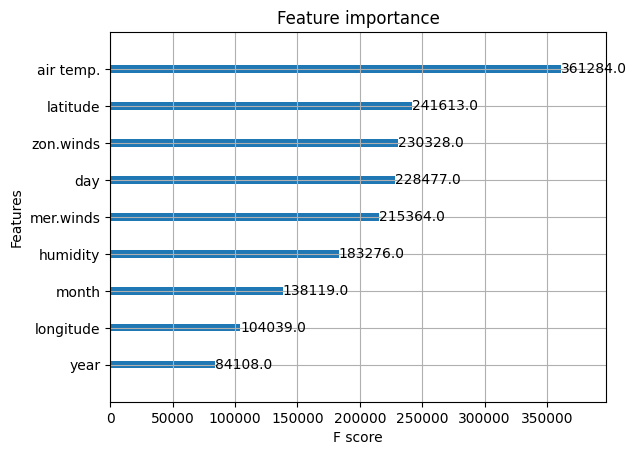

In [439]:
num_boost_round = 453
parameters['eval_metric'] = 'rmse'
parameters['n_estimators']=453
parameters['learning_rate']=0.05
print((parameters))
xgb.plot_importance(xgbFinal)

From the graph plotted above, we can see that our model has correctly captured the correlation between the features and the target variable.

## <b>Model Validation</b>

In [421]:
model=XGBRegressor(max_depth=14,min_child_weight=0.075,colsample_bytree=0.9,subsample=0.8,reg_alpha=0.01,reg_lambda=2.0000000000000003e-06,n_estimators=453,learning_rate=0.05)
model.fit(X_train,y_train)
print ("MSE Train : %f" % mean_absolute_error(y_train, model.predict(X_train))) 
print ("MSE Test: %f" % mean_absolute_error(y_val,model.predict(X_val)))
print(model.score(X_train,y_train)) #scoring done on training set
print(model.score(X_val,y_val)) #scoring done on validation set


MSE Train : 0.010333
MSE Test: 0.195812
0.9999510121243538
0.9830023873072757


As we can see, our model is capable if predicting with a <b>98.3%</b> accuracy on the validation dataset (we have made sure that no data is leaked between sets.). We had implemented <b>Pipelines</b> to do the same.

# <b>Generating output</b>

<h2>Prediction of evaluation dataset</h2>

In [435]:
model=XGBRegressor(max_depth=14,min_child_weight=0.075,colsample_bytree=0.9,subsample=0.8,reg_alpha=0.01,reg_lambda=2.0000000000000003e-06,n_estimators=453,learning_rate=0.05)
X_full=pd.DataFrame(myimputer.fit_transform(X_full)) #we impute the whole training data set
y_full=dataFrame['s.s.temp.']
X_full.columns=features
model.fit(X_full,y_full)
evalData=pd.read_csv('./evaluation.csv')


X_eval=evalData[features]
X_eval=pd.DataFrame(myimputer.transform(X_eval))# we transform the evaluation data based on our training data set
X_eval.columns=features

eval_result=pd.DataFrame(model.predict(X_eval))
eval_result.columns=['s.s.temp.']
eval_result.to_csv('eval_result.csv')

## Prediction of 1997-1998 dataset
<p>The model that we'd trained includes the year column which has values upto 1996. This data was contained within the evaluation dataset as well which is the reason that prompted us to include it. In this case the years can either be 1997 or 1998 (new to our model). </p>
<p>By excluding that column we believe that we should still be able to predict S.S.T. with reasonable accuracy as all the other features are given</p>

In [436]:
evalData_9798=pd.read_csv('data_1997_1998.csv')
new_features=[x for x in features if x!='year']

X_9798=dataFrame[new_features]
y_9798=y_full
new_imputer=SimpleImputer(strategy='median')
X_9798=pd.DataFrame(new_imputer.fit_transform(X_9798))
X_9798.columns=new_features

model=XGBRegressor(max_depth=14,min_child_weight=0.075,colsample_bytree=0.9,subsample=0.8,reg_alpha=0.01,reg_lambda=2.0000000000000003e-06,n_estimators=453,learning_rate=0.05)
# we use the same model as above.
model.fit(X_9798,y_9798)

X_eval_9798=evalData_9798[new_features]
X_eval_9798=pd.DataFrame(new_imputer.transform(X_eval_9798))
X_eval_9798.columns=new_features

eval_result_9798=pd.DataFrame(model.predict(X_eval_9798))
eval_result_9798.columns=['s.s.temp.']
eval_result_9798.to_csv('eval_9798_result.csv')